In [1130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as stats2
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
import inspect
import warnings
warnings.filterwarnings('ignore')


In [1131]:
df_prueba = pd.DataFrame({
"ES_NO_ES":[np.random.choice(['s','n']) for _ in range(1000)],
"sexo":[np.random.choice(['h','m']) for _ in range(1000)],
"Datos_C":[np.random.choice([0,1]) for _ in range(1000)],
"Datos_D": list(np.random.standard_normal(1000)),
"Datos_E": list(np.random.standard_normal(1000)),
"Datos_Poisson_1": list( stats.poisson.rvs(mu=4, size=1000)),
"Datos_Poisson_3": list( np.random.poisson(lam=10, size=1000)),
"Datos_Geom": list( stats.geom.rvs(0.75, size=1000)),
"Datos_F": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_G": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_cate_A": ['Grupo '+str(np.random.randint(0,6)) for _ in range(1000)],
"Datos_cate_B": ['Grupo '+str(np.random.randint(0,4)) for _ in range(1000)],

})

for i in range(1,6):
    df_prueba['Datos_E'][random.randint(0,23)]=None


for i in range(1,10):
    df_prueba['Datos_F'][random.randint(0,23)]=None

for i in range(0,11):
    df_prueba['Datos_G'][i]=None


In [1132]:

class DF_exploracion(pd.DataFrame):

    def __init__(self, *args, **kw):
        super(DF_exploracion, self).__init__(*args, **kw)
        self.cuanti=pd.DataFrame
        self.cuanti_antes_de_outliers_y_inputs=pd.DataFrame
        self.cuali=pd.DataFrame
        self.dico=pd.DataFrame
        self.cate=pd.DataFrame
        self.eliminado=pd.DataFrame
        self.dummy=pd.DataFrame
        self.df=pd.DataFrame
        self.df_inputado=pd.DataFrame
        self.df_limpio=pd.DataFrame
        self.normal_cuatis=[]
        self.normal_grupos_dico=[]
        self.normal_grupos_cate=[]
        self.discreta=[]
        self.stingg=[]
        
        
        self.porcentaje_nulos_permitido=0.6

    def variables(self):

        dico=[]
        cuantis=[]
        categori=[]
        eliminar=[]
        

        for i in self.columns: 

            try:
                datos=self[i].dropna().to_numpy()
                discreta=True
                for j in datos:
                    if (j%1 !=0):
                        discreta=False
                        break
                    else:
                        continue
                if (discreta):
                    self.discreta.append(i)
            except:
                self.stingg.append(i)

            nulos= (self[i].isnull().sum())/len(self[i])
            
            if ((len(self[i].dropna().unique())==2) and (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: DICOTOMICA"
                dico.append(i)

            elif ((len(self[i].dropna().unique())>10) and  (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CUANTITATIVA"
                cuantis.append(i)

            elif ( (len(self[i].dropna().unique())<2) or (nulos>self.porcentaje_nulos_permitido)):
                tipo_de_var=f"SOLO {len(self[i].dropna().unique())} TIPOS, NO VALE LA COLUMNA"
                eliminar.append(i)
            else:
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CATEGORICA/CUANTI"
                categori.append(i)

            print (f"|  {i} \n|   - Tipo de dato: {self[i].dtype} \n|   - Valores repetidos: {tipo_de_var} \n|   - Nulos: {nulos} \n| ")

        print (f"|----------------------------------------------------------------------------------------------------\n|  TODAS: {self.columns} \n|  DICOTOMICAS: {dico} \n|  CATEGORICAS: {categori} \n|  CUANTITATIVAS: {cuantis} \n|  ELIMINAR: {eliminar}")
        print("|----------------------------------------------------------------------------------------------------")

        


        self.DF_cuantis(cuantis)
        self.DF_cualis(categori+dico)
        self.DF_dicotomica(dico)
        self.DF_categorica(categori)
        self.DF_elimiminado(eliminar)
        self.df=self
        
    def todas_col(self):
        return self.df
    
    def DF_cuantis(self,lista):
        self.cuanti=self[lista]

    def DF_elimiminado(self,lista):
        self.eliminado=self[lista]
        
    def DF_cualis(self,lista):
        self.cuali=self[lista]
        
    def DF_dicotomica(self, lista):
        self.dico=self[lista]
        
    def DF_categorica(self, lista):
        self.cate=self[lista]   



    def limpiar_aux(self):
        
        try:
            df_nuevo=pd.DataFrame
            aux1=list(self.dico.columns)
            aux=[]
            df_nuevo=pd.get_dummies(self.df, columns=aux1)
            
            for columna in df_nuevo.columns:
                for variables in list(self.dico.columns):
                    if variables in columna:
                        aux.append(columna)
                    
            self.dummy=df_nuevo[aux]
            self[aux]=df_nuevo[aux]

            # self.df=self.drop(columns=var, axis='columns')
            # self.df= self[self.columns.difference(self.dico.columns)]
            
            print("********************** self.dummy ************\n")
            print(self.dummy)
            print("\n********************** self.df o todas_las_col() ************\n")
            print(self.df)

        except:
            print("---------------------- ERROR -----------------")



    def limpiar_dummys(self):

        b=False
        lista=list(self.dico.columns)
        for ind, i in enumerate(lista):
                if (ind+1<len(lista)):
                    if( (i in lista [ind+1]) ):
                        b=True
                        break
        if b:
            nombres_nuevos=[]
            if len(lista)>2:
                for ind, i in enumerate(lista):
                    if (ind+1<len(lista)):
                        if( (i in lista [ind+1]) ):
                            nombres_nuevos.append(i.upper())
                        else:
                            nombres_nuevos.append(i)
                    else:
                        nombres_nuevos.append(i)
                        
            aux_df=self.df

            for i,j in zip(lista,nombres_nuevos):
                aux_df.rename(columns={i:j},inplace=True)
                
            self.df=aux_df
            self.dico.columns=nombres_nuevos
            
            self.limpiar_aux()
        else: 
            self.limpiar_aux()



    def estadistica_descriptiva_cuantis(self):

        print("----------------------------------------------------------------------------------------------------\nDESCRIPCIÓN")
        print (self.cuanti.describe())
        print("\n")
        print("----------------------------------------------------------------------------------------------------\nCUARTILES")
        print (self.cuanti.quantile([0.05,0.25,0.5,0.75,0.95]))
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")


        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        # df_auxiliar = self.groupby('sexo').apply(lambda x: pd.Series(shapiro(x), index=['W','P'])).reset_index()
        # print(df_auxiliar)
                
        for a in list(aux1.values):
            
            for b in list(aux.values):
                
                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                agrupado=self.groupby(a)[b]
                titulo=f"Agrupado por {a} y por {b}"
                print(titulo)
                print(agrupado.describe().reset_index())
                # df.groupby(['cat1', 'cat2'])['purchases','sales'].apply(stats.shapiro)
                print("////////////////////////// TEST DE SHAPIRO ////////////////////////////")
                aux_shapiro=(agrupado.apply(stats.shapiro))
                print(aux_shapiro)
        
                
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")


    def estadistica_descriptiva_cualis(self):

        print("\n--------------------- Variables dico ---------------------")
        print("\n")
        for i in self.dico.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")

        print("\n-------------------- Variables categoricas --------------------")
        print("\n")
        for i in self.cate.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")
        print("\n\n")

        # crosstab variables cualis con cate
        aux=list(self.cate.columns)

        a=0
        for i in aux:
            a=a+1
            if a<len(aux)/2:
                b=0
                for j in aux[:-1]:
                    b=b+1
                    if b > a:
                        print(f"*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} *********************\n ")
                        tab = pd.crosstab (index=self[i], columns=self[j])
                        x=(tab/tab.sum())
                        print(tab)
                        print("\n")
                        print(f"/////////////////// EN PROPORCION //////////////////\n")
                        print(x)
                        print("\n\n")


    def anova(self):

        aux_cate=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for i in aux_cate:
            for j in aux_cuati:
                try:
                    print(f"\n----------- ANOVA Categoria {i} y variable continua {j} ----------\n")
                    model = ols(f"{j} ~ {i}", data=self).fit()
                    a=sm.stats.anova_lm(model, typ=2)
                    print(a)
                except:
                    print(f"\n - - - - - Fallo en variable {i} y {j} - - - - - - \n")
                    continue




    def Chi(self):

        aux_dico=list(self.dico.columns)

        if len(aux_dico)>1:
            for ind, i in enumerate(aux_dico):
                for j in range(ind+1,len(aux_dico)):
                    chi, p, dof, expected = stats.chi2_contingency(pd.crosstab(self[i],self[aux_dico[j]]), correction=False)
                    print(f"\n-------------- Chi2 entre {i} y {aux_dico[j]} ----------------")
                    print(f"p: {p} \n") 
        else:
            print("******************** No suficientes argumentos ********************")


    def t_test_aux(self, columns):
        results = []
        for i, col1 in enumerate(columns[:-1]):
            for col2 in columns[i+1:]:
                t, p = stats.ttest_ind(self[col1].dropna(), self[col2].dropna(), equal_var=False)
                # results.append((col1, col2, t, p))
                if p < 0.05:
                    print( f"+++++ Variable{col1}, variable 2 {col2} con p de: \033[1m{p}\033[0m  Se RECHAZA H0 ++++") 
                else:
                    print( f"+++++ Variable{col1}, variable 2 {col2}  con p de: {p} SE ACEPTA H0 ++++") 
    
    def wilcoxon_test_aux(self,col1, col2):
        if (col1== col2).all():
            print ("\nLas coluimnas son iguales\n")
        res = stats.wilcoxon(col1, col2)
        if res.pvalue < 0.05:
            print(f"Reject null hypothesis. Significant difference  (p-value={res.pvalue:.4f})")
        else:
            print (f"Fail to reject null hypothesis. No significant difference (p-value={res.pvalue:.4f})")

    def wilconxon(self, lista):
        # lista=[grupo, var]
        a,b=self.agrupar(lista)
        print(f"\n- Variable: {lista[1]}, Grupo: {lista[0]}")
        self.wilcoxon_test_aux(a, b)

    def agrupar (self, lista):
        groupby_col=lista[0]
        col=lista[1]
        valor=self[groupby_col].unique()
        group= self.where(self[groupby_col]== valor[0])[col]
        group2= self.where(self[groupby_col]== valor[1])[col] 
        return group,group2

    # def t_test_groupby_one_col(self, col, groupby_col):
        
    #     group= self.where(self[groupby_col]== self[groupby_col][0]).dropna()[col]
    #     group2= self.where(self[groupby_col]== self[groupby_col][1]).dropna()[col]
    #     t, p = stats.ttest_ind(group, group2, equal_var=False)
    #     print( col, groupby_col,p) 

    def t_test_all(self):
        aux=list(self.cuanti.columns)
        aux2=list(self.dico.columns)
        self.t_test_aux(self.normal_cuatis) #aqui ya hace todas las cuantis entre ellas faltan los grupos
        for i in self.normal_grupos_dico:
            a,b=self.agrupar(i)
            t, p = stats.ttest_ind(a.dropna(), b.dropna(), equal_var=False)
            if p < 0.05:
                print( f"+++++ Variable{i[1]}, Agrupado por {i[0]} con p de: \033[1m{p}\033[0m  Se RECHAZA H0 ++++") 
            else:
                print( f"+++++ Variable{i[1]}, Agrupado por {i[0]} con p de: {p} SE ACEPTA H0 ++++") 
    # df_prueba.groupby('sexo').apply(lambda df: stats.ttest_ind(df['Datos_D'].dropna(), df['Datos_E'].dropna())[1])

    # group2_air = df_prueba.where(df_prueba.sexo== 'm').dropna()['Datos_D']
    # stats.ttest_ind(group1_air,group2_air)[1]

    # df_grouped = df_prueba.groupby('sexo')
    # stats.ttest_ind(*df_grouped['Datos_D'])

    def plot_normailidad(self):

        aux=self.cuanti.columns
        for i in aux:
            stats.probplot(self[i], dist="norm", plot=plt)
            plt.title("Probability Plot - " )
            plt.show()
    


    def plot_bigotes(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

        print("-------------- Graficas de bigotes cualitativas-------------------")
        # fig = plt.figure(figsize=(12, 8))
        
        (self.cuanti).plot(kind='box', title='Variables cuantitativas',figsize=(12, 8))
        plt.show()
        

        print("-------------- Graficas de bigotes por dicotomicas-------------------")   
        
        for a in aux1:

            # fig = plt.figure(figsize=(12, 8))
            self.boxplot(column=list(aux.values), by=a,figsize=(12, 8))
            plt.tight_layout() 
            plt.show()
        
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- Graficas de bigotes por categoricas-------------------") 

        for a in aux2:
            # fig = plt.figure(figsize=(12, 8))
            ax= self.boxplot(column=list(aux.values), by=a, figsize=(12, 8))
            # ax = sns.swarmplot(column=list(aux.values), by=a,data=self, color='#7d0013')
            plt.tight_layout() 
            plt.show()
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")

        
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")



    def plot_corr(self):

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------\n") 

        fig = plt.figure(figsize=(12, 8))
        matrix = self.cuanti.corr().round(2)
        mask = np.triu(np.ones_like(matrix, dtype=bool))
        sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)  
        plt.show()

        print("----------------------------------------------------------------------------------------------------\n")

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def plot_barras(self):
        aux=self.cuanti.columns

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")

        print("-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------\n") 
        # fig = plt.figure(figsize=(15, 20))
        self.cuanti.plot.bar(figsize=(18, 8))
        plt.show()

        print("-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------\n") 
        for i in list(aux.values):
            fig = plt.figure(figsize=(12, 8))
            print(f"\n.............. GRAFICA DE BARRAS  DE {i} ............\n") 
            ax=self[i].plot.hist(density=True)
            self[i].plot.density(ax=ax)
            plt.show()

        print("----------------------------------------------------------------------------------------------------\n")    
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def todos_plots(self):

        self.plot_bigotes()
        self.plot_corr()
        self.plot_barras()
        self.violines()
        
        

    def violines(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        print("--------------  GRAFICA DE VIOLINES  -------------------\n") 
        sns.set(style="whitegrid")
        for i in aux2:
            for j in aux:
                ax= sns.violinplot(x=self[i], y=self[j], palette="Set2", split=True, inner="quartile",scale="count")
                plt.show()

        print("\n\n/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////\n") 
        
        for i in aux2:
            for j in aux:
                for k in aux1:
                    ax= sns.violinplot(x=self[i], y=self[j], hue=self[k],palette="Set2", split=True, inner="quartile",scale="count")
                    plt.show()


    def cross_var_cualis_con_ciantis(self):

        aux=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for k in aux_cuati:
            a=0
            for i in aux:
                a=a+1
                if a<len(aux)/2:
                    b=0
                    for j in aux[:-1]:
                        b=b+1
                        if b > a:
                            print(f"\n\n*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} con valores de {k} MEDIA *********************\n ")
                            tab = pd.crosstab (index=self[i], columns=self[j],values=self[k],aggfunc=np.mean)
                            print(tab)
                            print("\n\n")

    def nulos(self):
        aux_df=list(self.cuanti.columns)
        aux_DF=self.cuanti
        self.df_inputado=self.df
        for i in aux_df:
            nulos=aux_DF[i].isna().sum()
            total=len(aux_DF[i])
            porcentaje=nulos/total
            if ((nulos>0) and (porcentaje<self.porcentaje_nulos_permitido)):
                percen=aux_DF[i].quantile([0.2,0.8]).to_list()
                self.df_inputado[i]=aux_DF[i].apply(lambda x: ( random.randint ( round(percen[0]) , round(percen[1]) )) if pd.isna(x) else x )
                print(f"\n- Se han inputado {nulos} nulos a la variable {i} (tenía porcentaje de nulos de: {porcentaje}) \n")
            elif (porcentaje>self.porcentaje_nulos_permitido):
                print(f"\n - No se ha podido inputar a la variable {i} porque el porcentaje de nulos era de {porcentaje}\n")
                

    def normalidad(self):
        
        DataF=self.df
        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
                
        for b in list(aux.values):
            aux_shapiro=(stats.shapiro(DataF[b]))
            if(aux_shapiro.pvalue<0.05):
                print("////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////")
                print("++++++++++++++++++++++++++++  "+ b +"  ++++++++++++++++++++++++++\n")
                titulo=f"Variable cuantitativa {b} y test Shapiro < 0.05"
                print(titulo)
                print(aux_shapiro)
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")
                self.normal_cuatis.append(b)

        for a in list(aux1.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby(a)[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(aux_shapiro)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_dico.append([a,b])
                    except:
                        continue 

        for a in list(aux2.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby([a])[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO CATEGORICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(h)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_cate.append([a,b])
                    except:
                        continue 

        self.normal_grupos_dico=[i for n, i in enumerate(self.normal_grupos_dico) if i not in self.normal_grupos_dico[:n]]
        self.normal_grupos_cate=[i for n, i in enumerate(self.normal_grupos_cate) if i not in self.normal_grupos_cate[:n]]
        
    def detec_outlaiers(self):
        aux=list(self.cuanti.columns)
        aux_DF=self.cuanti
        for i in aux:
            z = np.abs(stats.zscore(aux_DF[i]))
            print(z)
    
    def seleccionar_distribuciones(self,familia='realall', verbose=False):
        '''
        Parameters
        ----------
        familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
            realall: distribuciones de la familia `realline` + `realplus`
            realline: distribuciones continuas en el dominio (-inf, +inf)
            realplus: distribuciones continuas en el dominio [0, +inf)
            real0to1: distribuciones continuas en el dominio [0,1]
            discreta: distribuciones discretas
            
        verbose : bool
            Si se muestra información de las distribuciones seleccionadas
            (the default `False`)
        '''
    
        distribuciones = [getattr(stats,d) for d in dir(stats) \
                        if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
        
        exclusiones = ['levy_stable', 'vonmises']
        distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
                
        dominios = {
            'realall' : [-np.inf, np.inf],
            'realline': [np.inf,np.inf],
            'realplus': [0, np.inf],
            'real0to1': [0, 1], 
            'discreta': [None, None],
        }

        distribucion = []
        tipo = []
        dominio_inf = []
        dominio_sup = []

        for dist in distribuciones:
            distribucion.append(dist.name)
            tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
            dominio_inf.append(dist.a)
            dominio_sup.append(dist.b)
        
        info_distribuciones = pd.DataFrame({
                                'distribucion': distribucion,
                                'tipo': tipo,
                                'dominio_inf': dominio_inf,
                                'dominio_sup': dominio_sup
                            })

        info_distribuciones = info_distribuciones \
                            .sort_values(by=['dominio_inf', 'dominio_sup'])\
                            .reset_index(drop=True)
        
        if familia in ['realall', 'realline', 'realplus', 'real0to1']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
            condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                        (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
            info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
            
        if familia in ['discreta']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
            
        seleccion = [dist for dist in distribuciones \
                    if dist.name in info_distribuciones['distribucion'].values]
        
        
        if verbose:
            print("---------------------------------------------------")
            print("       Distribuciones seleccionadas                ")
            print("---------------------------------------------------")
            with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
                print(info_distribuciones)
        
        return seleccion


    def plot_multiple_distribuciones(self, nombre_distribuciones):

        aux=list(self.cuanti.columns)
        fig, ax = plt.subplots(figsize=(15,15))

        for i in aux:
            x=self[i]
            if ax is None:
                fig, ax = plt.subplots(figsize=(7,4))
                
            ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
            ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
            ax.set_title('Ajuste distribuciones')
            ax.set_xlabel('x')
            ax.set_ylabel('Densidad de probabilidad')
            
            for nombre in nombre_distribuciones:
                
                distribucion = getattr(stats, nombre)

                parametros = distribucion.fit(data=x)

                nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                    if not p=='x'] + ["loc","scale"]
                parametros_dict = dict(zip(nombre_parametros, parametros))

                log_likelihood = distribucion.logpdf(x, *parametros).sum()

                aic = -2 * log_likelihood + 2 * len(parametros)
                bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                x_hat = np.linspace(min(x), max(x), num=100)
                y_hat = distribucion.pdf(x_hat, *parametros)
                ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
            ax.legend()
            plt.show()
        


    def fit_discrete(self,datos):

        # self.discreta

        mean = datos.mean()
        var = datos.var()
        likelihoods = {}  
        log_likelihoods = {}

        p = 1 - mean / var  
        r = (1-p) * mean / p



        log_likelihoods['nbinom'] = datos.map(lambda val: stats.nbinom.logpmf(val, r, p)).sum()

        lambda_ = mean

        log_likelihoods['poisson'] = datos.map(lambda val: stats.poisson.logpmf(val, lambda_)).sum()


        best_fit = max(log_likelihoods, key=lambda x: log_likelihoods[x])
        print("**** Best fit between poisson and nbinorm :", best_fit)
        

    
        plt.hist(datos, bins=int(np.max(datos)), density=True, alpha=0.5)

        mean = datos.mean()
        var = datos.var()


        def loss_function_poisson(params, datos_in):

            mu = params[0]

            loss = 0

            for i in range(len(datos_in)):

                loglikelihood = stats.poisson.logpmf(datos_in[i], mu)

                loss_to_add = -loglikelihood

                loss += loss_to_add

            return(loss)




        params0 = np.array([20])
        minimum = stats2.optimize.fmin(loss_function_poisson, params0, args=(datos,))

        mu_fit = minimum[0]

        print("***********  The best mu_fit is:  ",  mu_fit)
        print("\n")

        x = list(range(int(np.min(datos)), int(np.max(datos))+1))
        plt.scatter(x, stats.poisson.pmf(x, mu_fit),color="red")
        plt.show()   

        print("\n\n Otras variables discretas:  ",  self.discreta)


    def comparar_distribuciones_caunti_cont(self, ordenar='aic', verbose=False):

            '''
            resultados: data.frame
                distribucion: nombre de la distribución.
                log_likelihood: logaritmo del likelihood del ajuste.
                aic: métrica AIC.
                bic: métrica BIC.
                n_parametros: número de parámetros de la distribución de la distribución.
                parametros: parámetros del tras el ajuste
                
            Raises
            ------
            Exception
                Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
                o 'discreta'.
                
            Notes
            -----
            '''
            aux=list(self.cuanti.columns)
            
            for i in aux:
                print(f"\n ******************** Variable: {i} ******************** \n")
                x=self[i]
                distribuciones = self.seleccionar_distribuciones(familia='realall',verbose=verbose)
                distribucion_ = []
                log_likelihood_= []
                aic_ = []
                bic_ = []
                n_parametros_ = []
                parametros_ = []
                
                for j, distribucion in enumerate(distribuciones):
                    
                    # print(f"{j+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
                    
                    try:
                        parametros = distribucion.fit(data=x)
                        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                            if not p=='x'] + ["loc","scale"]
                        parametros_dict = dict(zip(nombre_parametros, parametros))
                        log_likelihood = distribucion.logpdf(x, *parametros).sum()
                        aic = -2 * log_likelihood + 2 * len(parametros)
                        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
                        
                        distribucion_.append(distribucion.name)
                        log_likelihood_.append(log_likelihood)
                        aic_.append(aic)
                        bic_.append(bic)
                        n_parametros_.append(len(parametros))
                        parametros_.append(parametros_dict)
                        
                        resultados = pd.DataFrame({
                                        'distribucion': distribucion_,
                                        'log_likelihood': log_likelihood_,
                                        'aic': aic_,
                                        'bic': bic_,
                                        'n_parametros': n_parametros_,
                                        'parametros': parametros_,
                            
                                    })
                        
                        resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)

                        
                        
                    except Exception as e:
                        print(f"Error al tratar de ajustar la distribución {distribucion.name}")
                        print(e)
                        print("")

                nombre_distribuciones=resultados['distribucion'][:5]
                fig, ax = plt.subplots(figsize=(7,4))
                
                
                ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
                ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
                ax.set_title('Ajuste distribuciones')
                ax.set_xlabel('x')
                ax.set_ylabel('Densidad de probabilidad')
                
                for nombre in nombre_distribuciones:
                    
                    distribucion = getattr(stats, nombre)

                    parametros = distribucion.fit(data=x)

                    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                        if not p=='x'] + ["loc","scale"]
                    parametros_dict = dict(zip(nombre_parametros, parametros))

                    log_likelihood = distribucion.logpdf(x, *parametros).sum()

                    aic = -2 * log_likelihood + 2 * len(parametros)
                    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                    x_hat = np.linspace(min(x), max(x), num=100)
                    y_hat = distribucion.pdf(x_hat, *parametros)
                    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
                ax.legend()
                plt.show()

                print("\n")
                print(resultados.head(5))    
                print("\n------------------------------------------------------------------\n")

    def remove_outliers(self, k=1.5):
        aux=list(self.cuanti.columns)
        for column in aux:
            print(f"\n\n                    <<<<<<<<<<<<<<<<<<<<<<<< {column} >>>>>>>>>>>>>>>>>>>>>>>>\n\n")
            self.plot_outliers2(column, k=1.5)
            q1, q3 = self[column].quantile([0.25, 0.75])
            iqr = q3 - q1
            lower_bound = q1 - (k * iqr)
            upper_bound = q3 + (k * iqr)
            self.loc[(self[column] < lower_bound) | (self[column] > upper_bound), column] = None    
        self.nulos()


    def plot_outliers(self, column, k=1.5):
        
        q1, q3 = self[column].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - (k * iqr)
        upper_bound = q3 + (k * iqr)
        
        fig, ax = plt.subplots()
        ax.scatter(self.index, self[column], color='blue', label='inlier')
        ax.scatter(self[(self[column] < lower_bound) | (self[column] > upper_bound)].index,
                self[(self[column] < lower_bound) | (self[column] > upper_bound)][column],
                color='red', label='outlier')
        ax.axhline(lower_bound, color='gray', linestyle='--')
        ax.axhline(upper_bound, color='gray', linestyle='--')
        plt.legend()
        plt.show() 

    
    def plot_outliers2(df, column, k=1.5):
        q1, q3 = df[column].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - (k * iqr)
        upper_bound = q3 + (k * iqr)
        
        fig, ax = plt.subplots()
        ax.plot(df.index, df[column], color='blue')
        ax.scatter(df[df[column].isnull()].index,
                df[df[column].isnull()][column],
                color='red', marker='x')
        ax.axhline(lower_bound, color='red', linestyle='--')
        ax.axhline(upper_bound, color='red', linestyle='--')
        plt.show()
        
    def plot_xy_data(df, x_column, y_column):
        fig, ax = plt.subplots()
        ax.scatter(df[x_column], df[y_column])
        plt.xlabel(x_column)
        plt.ylabel(y_column)
        plt.show()


# CREACIÓN DE LA CLASE

In [1133]:
ejemplo=DF_exploracion(df_prueba)


In [1134]:
ejemplo.cuanti.columns

# DEFINICIÓN DE LAS VARIABLES

In [1135]:
ejemplo.variables()


|  ES_NO_ES 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  sexo 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_C 
|   - Tipo de dato: int32 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_D 
|   - Tipo de dato: float64 
|   - Valores repetidos: 1000 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_E 
|   - Tipo de dato: float64 
|   - Valores repetidos: 996 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.004 
| 
|  Datos_Poisson_1 
|   - Tipo de dato: int64 
|   - Valores repetidos: 13 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Poisson_3 
|   - Tipo de dato: int32 
|   - Valores repetidos: 21 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Geom 
|   - Tipo de dato: int64 
|   - Valores repetidos: 5 tipos, posiblemente: CATEGORICA/CUANTI 
|   - Nulos: 0

## Creación de variables dummys a traves de dicotómicas

In [1136]:
ejemplo.limpiar_dummys()

********************** self.dummy ************

     ES_NO_ES_n  ES_NO_ES_s  sexo_h  sexo_m  Datos_C_0  Datos_C_1
0             0           1       1       0          0          1
1             0           1       0       1          1          0
2             0           1       1       0          1          0
3             0           1       0       1          1          0
4             0           1       0       1          1          0
..          ...         ...     ...     ...        ...        ...
995           1           0       1       0          1          0
996           1           0       1       0          0          1
997           1           0       0       1          1          0
998           1           0       1       0          1          0
999           1           0       0       1          1          0

[1000 rows x 6 columns]

********************** self.df o todas_las_col() ************

    ES_NO_ES sexo  Datos_C   Datos_D   Datos_E  Datos_Poisson_1  \
0   

## Revisión de todas las columnas

In [1137]:
# ejemplo.df
# ejemplo.cuanti
# ejemplo.dummy
# ejemplo.dico
ejemplo.df


,ES_NO_ES,sexo,Datos_C,Datos_D,Datos_E,Datos_Poisson_1,Datos_Poisson_3,Datos_Geom,Datos_F,Datos_G,Datos_cate_A,Datos_cate_B,ES_NO_ES_n,ES_NO_ES_s,sexo_h,sexo_m,Datos_C_0,Datos_C_1
0,s,h,1,-0.410254,0.247803,3,11,2,230.0,NaN,Grupo 5,Grupo 1,0,1,1,0,0,1
1,s,m,0,-0.413145,0.436075,2,20,1,378.0,NaN,Grupo 3,Grupo 3,0,1,0,1,1,0
2,s,h,0,-1.504048,-0.477248,5,9,1,132.0,NaN,Grupo 3,Grupo 0,0,1,1,0,1,0
3,s,m,0,0.670278,0.356155,3,7,1,8.0,NaN,Grupo 0,Grupo 2,0,1,0,1,1,0
4,s,m,0,1.413180,-0.452148,2,10,2,NaN,NaN,Grupo 3,Grupo 2,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,n,h,0,1.457616,1.304462,3,10,1,841.0,578.0,Grupo 1,Grupo 3,1,0,1,0,1,0
996,n,h,1,-0.240152,-1.467517,0,12,1,998.0,732.0,Grupo 2,Grupo 3,1,0,1,0,0,1
997,n,m,0,1.151471,-0.077022,3,11,1,410.0,639.0,Grupo 2,Grupo 0,1,0,0,1,1,0
998,n,h,0,1.064936,1.080703,5,19,2,906.0,601.0,Grupo 3,Grupo 2,1,0,1,0,1,0


## Revisión de variables agrupadas automaticamente

In [1138]:
print(f" Datos con distribución discreta: {ejemplo.discreta}")
print(f"Datos de tipos string seguramente: {ejemplo.stingg}")
        

 Datos con distribución discreta: ['Datos_C', 'Datos_Poisson_1', 'Datos_Poisson_3', 'Datos_Geom', 'Datos_F', 'Datos_G']
Datos de tipos string seguramente: ['ES_NO_ES', 'sexo', 'Datos_cate_A', 'Datos_cate_B']


# ESTADISTICA DESCRIPTIVA

In [1139]:
ejemplo.estadistica_descriptiva_cuantis()

----------------------------------------------------------------------------------------------------
DESCRIPCIÓN
           Datos_D     Datos_E  Datos_Poisson_1  Datos_Poisson_3     Datos_F  \
count  1000.000000  996.000000      1000.000000      1000.000000  992.000000   
mean     -0.022850   -0.002044         4.023000        10.099000  489.618952   
std       1.038658    1.017367         2.020533         3.160884  282.768795   
min      -3.478106   -2.921367         0.000000         2.000000    0.000000   
25%      -0.719755   -0.715720         3.000000         8.000000  237.750000   
50%      -0.018103    0.009302         4.000000        10.000000  482.000000   
75%       0.728514    0.643339         5.000000        12.000000  728.000000   
max       2.824569    3.982457        12.000000        23.000000  999.000000   

          Datos_G  
count  989.000000  
mean   491.564206  
std    295.753938  
min      2.000000  
25%    217.000000  
50%    480.000000  
75%    744.000000  
max   

In [1140]:
ejemplo.estadistica_descriptiva_cualis()


--------------------- Variables dico ---------------------


...........Frecuencia variable ES_NO_ES ....................
n    0.515
s    0.485
Name: ES_NO_ES, dtype: float64


...........Frecuencia variable sexo ....................
m    0.501
h    0.499
Name: sexo, dtype: float64


...........Frecuencia variable Datos_C ....................
1    0.512
0    0.488
Name: Datos_C, dtype: float64



-------------------- Variables categoricas --------------------


...........Frecuencia variable Datos_Geom ....................
1    0.739
2    0.203
3    0.043
4    0.012
5    0.003
Name: Datos_Geom, dtype: float64


...........Frecuencia variable Datos_cate_A ....................
Grupo 0    0.180
Grupo 3    0.172
Grupo 2    0.170
Grupo 1    0.169
Grupo 4    0.158
Grupo 5    0.151
Name: Datos_cate_A, dtype: float64


...........Frecuencia variable Datos_cate_B ....................
Grupo 1    0.273
Grupo 0    0.252
Grupo 2    0.240
Grupo 3    0.235
Name: Datos_cate_B, dtype: float64





***

In [1141]:
ejemplo.cross_var_cualis_con_ciantis()



*************** TABAL DE VARIABLES CATEGORICAS Datos_Geom y Datos_cate_A con valores de Datos_D MEDIA *********************
 
Datos_cate_A   Grupo 0   Grupo 1   Grupo 2   Grupo 3   Grupo 4   Grupo 5
Datos_Geom                                                              
1            -0.094441 -0.042241  0.099464  0.053621 -0.080375 -0.074612
2             0.126660 -0.112974  0.104672 -0.278690 -0.153315 -0.014291
3             0.046233 -0.122571  0.247401  0.271818  0.054291  0.560908
4            -1.874656  0.267802  0.297059  0.181927       NaN  0.006550
5                  NaN  0.996130       NaN -0.353041       NaN       NaN





*************** TABAL DE VARIABLES CATEGORICAS Datos_Geom y Datos_cate_A con valores de Datos_E MEDIA *********************
 
Datos_cate_A   Grupo 0   Grupo 1   Grupo 2   Grupo 3   Grupo 4   Grupo 5
Datos_Geom                                                              
1             0.038439  0.043094 -0.037643  0.134739 -0.128918 -0.015459
2          

## Variables normales y no normales

In [1142]:
ejemplo.normalidad()

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_Poisson_1  ++++++++++++++++++++++++++

Variable cuantitativa Datos_Poisson_1 y test Shapiro < 0.05
ShapiroResult(statistic=0.9641100168228149, pvalue=5.5826522773344284e-15)


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_Poisson_3  ++++++++++++++++++++++++++

Variable cuantitativa Datos_Poisson_3 y test Shapiro < 0.05
ShapiroResult(statistic=0.9837534427642822, pvalue=4.144571352782123e-09)


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////
++++++++++++++++++++++++++++  ES_NO_ES y Datos_Poisson_1  ++++++++++++++++++++++++++

Agrupado por ES_NO_ES y por Dat

## Agrupación normal por categoricas

In [1143]:
ejemplo.normal_grupos_cate

[['Datos_Geom', 'Datos_Poisson_1'],
 ['Datos_Geom', 'Datos_Poisson_3'],
 ['Datos_Geom', 'Datos_G'],
 ['Datos_cate_A', 'Datos_D'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_F'],
 ['Datos_cate_A', 'Datos_G'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_3']]

## Agrupación normalidad por dicotomicas

In [1144]:
ejemplo.normal_grupos_dico

[['ES_NO_ES', 'Datos_Poisson_1'],
 ['ES_NO_ES', 'Datos_Poisson_3'],
 ['sexo', 'Datos_Poisson_1'],
 ['sexo', 'Datos_Poisson_3'],
 ['Datos_C', 'Datos_Poisson_1'],
 ['Datos_C', 'Datos_Poisson_3']]

## Quitar outlayers e inputar datos en columnas variables cuantitativas 



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_D >>>>>>>>>>>>>>>>>>>>>>>>




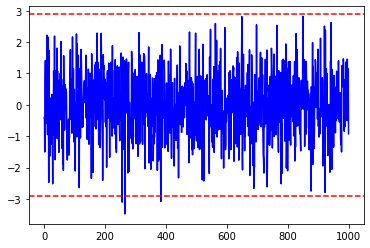



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_E >>>>>>>>>>>>>>>>>>>>>>>>




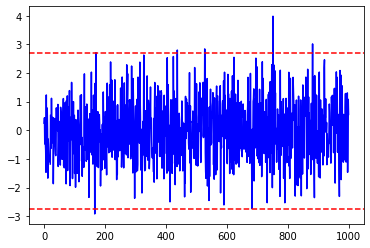



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_Poisson_1 >>>>>>>>>>>>>>>>>>>>>>>>




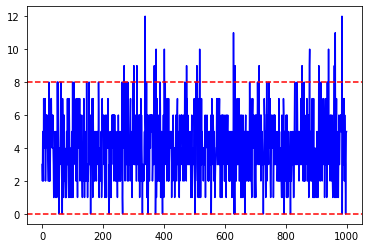



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_Poisson_3 >>>>>>>>>>>>>>>>>>>>>>>>




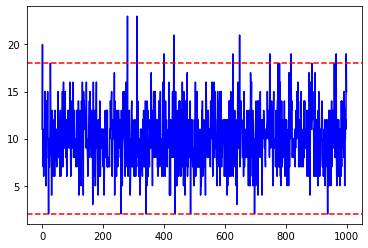



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_F >>>>>>>>>>>>>>>>>>>>>>>>




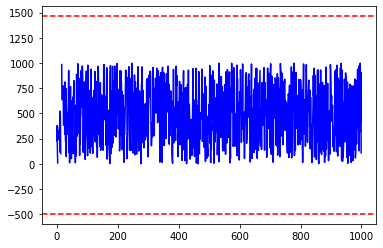



                    <<<<<<<<<<<<<<<<<<<<<<<< Datos_G >>>>>>>>>>>>>>>>>>>>>>>>




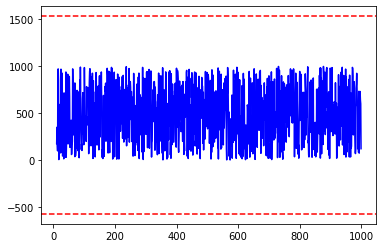


- Se han inputado 4 nulos a la variable Datos_E (tenía porcentaje de nulos de: 0.004) 


- Se han inputado 8 nulos a la variable Datos_F (tenía porcentaje de nulos de: 0.008) 


- Se han inputado 11 nulos a la variable Datos_G (tenía porcentaje de nulos de: 0.011) 



In [1145]:
ejemplo.remove_outliers()

## Ajustar a distribuciones variables cuantitativas (No puede haber nulos)

In [1146]:
# ejemplo.comparar_distribuciones_caunti_cont()

## Ajustar a distribuciones variables discretas (No puede haber nulos) (Solo poisson y binomial)

In [1147]:
# ejemplo.fit_discrete(df_prueba["Datos_Poisson_1"])

# PLOTS

In [1148]:
#ejemplo.todos_plots()

In [1149]:
# ejemplo.plot_bigotes()

In [1150]:
# ejemplo.plot_barras()

In [1151]:
# ejemplo.plot_corr()

In [1152]:
# ejemplo.violines()

In [1153]:
# ejemplo.plot_normailidad()

# TEST ESTADISTICOS NO MULTIVARIANTE

## Variables cualitativas

### Chi2

In [1154]:
# ejemplo.Chi()

## Variables cuantitativas no pareadas

### T_student

In [1155]:
ejemplo.t_test_all()

+++++ VariableDatos_Poisson_1, variable 2 Datos_Poisson_3 con p de: 0.0  Se RECHAZA H0 ++++
+++++ VariableDatos_Poisson_1, Agrupado por ES_NO_ES con p de: 0.029234261603989578  Se RECHAZA H0 ++++
+++++ VariableDatos_Poisson_3, Agrupado por ES_NO_ES con p de: 0.7293238451043726 SE ACEPTA H0 ++++
+++++ VariableDatos_Poisson_1, Agrupado por sexo con p de: 0.28470867905120767 SE ACEPTA H0 ++++
+++++ VariableDatos_Poisson_3, Agrupado por sexo con p de: 0.7579507272371695 SE ACEPTA H0 ++++
+++++ VariableDatos_Poisson_1, Agrupado por Datos_C con p de: 0.31457348560685905 SE ACEPTA H0 ++++
+++++ VariableDatos_Poisson_3, Agrupado por Datos_C con p de: 0.0024836365163359467  Se RECHAZA H0 ++++


### Wilconxon

In [1156]:
ejemplo.wilconxon( ["sexo","Datos_D" ])


- Variable: Datos_D, Grupo: sexo
Fail to reject null hypothesis. No significant difference (p-value=nan)


## Anova

In [1157]:
# ejemplo.anova()

# Intervalos de confianza